# GOING DEEPER 06 : OCR

## 준비한 데이터

- lmdb 데이터셋  
  - LMDB는 Symas에서 만든 Lightning Memory-Mapped Database의 약자이다.
  - 지금부터 다루게 될 데이터셋이 lmdb 포맷(mdb)의 파일로 이루어져 있다.

## 0. 라이브러리 import 및 데이터셋 준비

In [1]:
import re
import six
import math
import lmdb
import os
import numpy as np
import tensorflow as tf

from PIL import Image

from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.utils import Sequence
from tensorflow.keras import backend as K
from tensorflow.keras.models import load_model

BATCH_SIZE = 128
HOME_DIR = os.getenv('HOME')+'/aiffel/ocr'

TRAIN_DATA_PATH = HOME_DIR+'/data/MJ/MJ_train'
VALID_DATA_PATH = HOME_DIR+'/data/MJ/MJ_valid'
TEST_DATA_PATH = HOME_DIR+'/data/MJ/MJ_test'

print(TRAIN_DATA_PATH)

/aiffel/aiffel/ocr/data/MJ/MJ_train


original image width:72, height:31
target_img_size:(74, 32)
display img shape:(74, 32, 3)
label:Lube


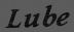

original image width:82, height:31
target_img_size:(84, 32)
display img shape:(84, 32, 3)
label:Spencerian


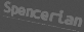

original image width:115, height:31
target_img_size:(100, 32)
display img shape:(100, 32, 3)
label:accommodatingly


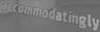

original image width:140, height:31
target_img_size:(100, 32)
display img shape:(100, 32, 3)
label:CARPENTER


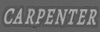

In [2]:
from IPython.display import display

env = lmdb.open(TRAIN_DATA_PATH, max_readers=32, readonly=True, lock=False, readahead=False, meminit=False)
with env.begin(write=False) as txn:
    for index in range(1, 5):
        label_key = 'label-%09d'.encode() % index
        label = txn.get(label_key).decode('utf-8')
        img_key = 'image-%09d'.encode() % index
        imgbuf = txn.get(img_key)
        buf = six.BytesIO()
        buf.write(imgbuf)
        buf.seek(0)
        try:
            img = Image.open(buf).convert('RGB')

        except IOError:
            img = Image.new('RGB', (100, 32))
            label = '-'
        width, height = img.size
        print('original image width:{}, height:{}'.format(width, height))
        
        target_width = min(int(width*32/height), 100)
        target_img_size = (target_width,32 )
        
        print('target_img_size:{}'.format(target_img_size))
        
        img = np.array(img.resize(target_img_size)).transpose(1,0,2)
       
        print('display img shape:{}'.format(img.shape))
        print('label:{}'.format(label))
        display(Image.fromarray(img.transpose(1,0,2).astype(np.uint8)))

In [3]:
class MJDatasetSequence(Sequence):
    def __init__(self, 
                      dataset_path,
                      label_converter,   # 문자를 미리 정의된 index로 변환해주는 converter
                      batch_size=1,
                      img_size=(100,32),
                      max_text_len=22,   # 필터링을 위한 최대 글자 수
                      is_train=False,
                      character=''       # 학습대상으로 한정하기 위한 character
                ):
        
        self.label_converter = label_converter
        self.batch_size = batch_size
        self.img_size = img_size
        self.max_text_len = max_text_len
        self.character = character
        self.is_train = is_train
        self.divide_length = 100

        self.env = lmdb.open(dataset_path, max_readers=32, readonly=True, lock=False, readahead=False, meminit=False)
        with self.env.begin(write=False) as txn:
            num_samples = int(txn.get('num-samples'.encode()))
            self.num_samples = int(num_samples)
            self.index_list = [index + 1 for index in range(self.num_samples)]
        
    def __len__(self):
        if self.is_train:
            return math.ceil(self.num_samples/self.batch_size/self.divide_length)
        return math.ceil(self.num_samples/self.batch_size/self.divide_length)
    
    # index에 해당하는 image와 label을 가져오는 메소드
    def _get_img_label(self, index):
        with self.env.begin(write=False) as txn:
            label_key = 'label-%09d'.encode() % index
            label = txn.get(label_key).decode('utf-8')
            img_key = 'image-%09d'.encode() % index
            imgbuf = txn.get(img_key)

            buf = six.BytesIO()
            buf.write(imgbuf)
            buf.seek(0)
            try:
                img = Image.open(buf).convert('RGB')

            except IOError:
                img = Image.new('RGB', self.img_size)
                label = '-'
            width, height = img.size
            
            target_width = min(int(width*self.img_size[1]/height), self.img_size[0])
            target_img_size = (target_width,self.img_size[1] )
            img = np.array(img.resize(target_img_size)).transpose(1,0,2)
            label = label.upper()[:self.max_text_len]
            out_of_char = f'[^{self.character}]'
            label = re.sub(out_of_char, '', label)

        return (img, label)
    
    # idx번째 배치를 가져오는 메소드
    def __getitem__(self, idx):
        batch_indicies = self.index_list[
            idx*self.batch_size:
            (idx+1)*self.batch_size
        ]
        input_images = np.zeros([self.batch_size, *self.img_size, 3])
        labels = np.zeros([self.batch_size, self.max_text_len], dtype='int64')

        input_length = np.ones([self.batch_size], dtype='int64')*self.max_text_len
        label_length = np.ones([self.batch_size], dtype='int64')

        for i, index in enumerate(batch_indicies):
            img, label = self._get_img_label(index)
            encoded_label = self.label_converter.encode(label)
            width = img.shape[0]
            input_images[i,:width,:,:] = img
            if len(encoded_label) > self.max_text_len:
                continue
            labels[i,0:len(encoded_label)] = encoded_label
            label_length[i] = len(encoded_label)

        inputs = {
            'input_image': input_images,
            'label': labels,
            'input_length': input_length,
            'label_length': label_length,
        }
        outputs = {'ctc': np.zeros([self.batch_size, 1])}
        return inputs, outputs
        
    def on_epoch_end(self):
        self.index_list =  [index + 1 for index in range(self.num_samples)]
        if self.is_train :
            np.random.shuffle(self.index_list)
            return self.index_list

## 1. Recognition model

### Encode
- 이미지의 Label이 평문 Text로 이루어져 있으므로, 각 Character를 class로 생각하고 이를 step에 따른 class index로 변환해서 encode 해주어야 한다.

In [4]:
class LabelConverter(object):
    """ Convert between text-label and text-index """

    def __init__(self, character):
        self.character = "-" + character
        self.label_map = dict()
        for i, char in enumerate(self.character):
            self.label_map[char] = i

    def encode(self, text):
        encoded_label = []
        for i, char in enumerate(text):
            if i > 0 and char == text[i - 1]:
                encoded_label.append(0)    # 같은 문자 사이에 공백 문자 label을 삽입
            encoded_label.append(self.label_map[char])
        return np.array(encoded_label)

    def decode(self, encoded_label):
        target_characters = list(self.character)
        decoded_label = ""
        for encode in encoded_label:
            decoded_label += self.character[encode]
        return decoded_label

- __init__(): 입력으로 받은 text를 self.dict에 각 character들이 어떤 index에 매핑되는지 저장한다. 이 character와 index 정보를 통해 모델이 학습할 수 있는 output이 만들어진다. 만약 character='ABCD'라면 'A'의 label은 1, 'B'의 label은 2가 된다.
- 공백(blank) 문자 지정: 공백 문자를 뜻하기 위해 '-'를 활용하며, label은 0으로 지정한다.
- encode(): 입력받은 text를 모델이 학습할 수 있는 label로 변환해준다. 같은 글자가 연속으로 이어지는 경우에는 그 사이에 공백 문자의 label을 포함해야 한다.
- decode(): 각 index를 다시 character로 변환한 후 이어주어 우리가 읽을 수 있는 text로 바꾸어준다.

In [5]:
NUMBERS = "0123456789"
ENG_CHAR_UPPER = "ABCDEFGHIJKLMNOPQRSTUVWXYZ"
TARGET_CHARACTERS = ENG_CHAR_UPPER + NUMBERS
print(f"The total number of characters is {len(TARGET_CHARACTERS)}")

The total number of characters is 36


In [6]:
# 'HELLO'를 Encode한 후 Decode가 정상적으로 되는지 확인
label_converter = LabelConverter(TARGET_CHARACTERS)

encdoded_text = label_converter.encode('HELLO')
print("Encdoded_text: ", encdoded_text)
decoded_text = label_converter.decode(encdoded_text)
print("Decoded_text: ", decoded_text)

Encdoded_text:  [ 8  5 12  0 12 15]
Decoded_text:  HEL-LO


### Build CRNN model

In [7]:
def ctc_lambda_func(args): # CTC loss를 계산하기 위한 Lambda 함수
    labels, y_pred, label_length, input_length = args
    y_pred = y_pred[:, 2:, :]
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)

- ctc_lambda_func: Keras에서 제공하는 K.ctc_batch_cost()를 활용해서 CTC loss를 계산하기 위한 함수
  - 이미지에서 텍스트 라벨을 추론해야 하는 Text recognition 태스크에 CTC Loss를 사용한다.
  - 입력의 길이 T와 라벨의 길이 U의 단위가 일치하지 않을 때, 라벨은 APPLE이지만 모델이 출력한 결과는 AAAPPPPLLLLEE 처럼 나올 수 있다. 이런 이유로 이전 스텝에서 LabelConverter.encode() 메소드에 공백문자 처리로직을 포함했던 것이다.

In [8]:
def build_crnn_model(input_shape=(100,32,3), characters=TARGET_CHARACTERS):
    num_chars = len(characters)+2
    image_input = layers.Input(shape=input_shape, dtype='float32', name='input_image')

    # Build CRNN model
    conv = layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(image_input)
    conv = layers.MaxPooling2D(pool_size=(2, 2))(conv)
    conv = layers.Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.MaxPooling2D(pool_size=(2, 2))(conv)
    conv = layers.Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.MaxPooling2D(pool_size=(1, 2))(conv)
    conv = layers.Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.BatchNormalization()(conv)
    conv = layers.Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.BatchNormalization()(conv)
    conv = layers.MaxPooling2D(pool_size=(1, 2))(conv)     
    feature = layers.Conv2D(512, (2, 2), activation='relu', kernel_initializer='he_normal')(conv)
    sequnce = layers.Reshape(target_shape=(24, 512))(feature)
    sequnce = layers.Dense(64, activation='relu')(sequnce)
    sequnce = layers.Bidirectional(layers.LSTM(256, return_sequences=True))(sequnce)
    sequnce = layers.Bidirectional(layers.LSTM(256, return_sequences=True))(sequnce)
    y_pred = layers.Dense(num_chars, activation='softmax', name='output')(sequnce)

    labels = layers.Input(shape=[22], dtype='int64', name='label')
    input_length = layers.Input(shape=[1], dtype='int64', name='input_length')
    label_length = layers.Input(shape=[1], dtype='int64', name='label_length')
    loss_out = layers.Lambda(ctc_lambda_func, output_shape=(1,), name="ctc")(
        [labels, y_pred, label_length, input_length]
    )
    model_input = [image_input, labels, input_length, label_length]
    model = Model(
        inputs=model_input,
        outputs=loss_out
    )
    y_func = tf.keras.backend.function(image_input, [y_pred])
    return model, y_func

 - build_crnn_model(): K.ctc_batch_cost()를 활용하여, image_input을 입력으로 그리고 마지막 Label을 'output'이라는 이름으로 출력하는 레이어를 갖도록 모델을 만드는 함수

### Train & Inference

In [9]:
train_set = MJDatasetSequence(TRAIN_DATA_PATH, label_converter, batch_size=BATCH_SIZE, character=TARGET_CHARACTERS, is_train=True)
val_set = MJDatasetSequence(VALID_DATA_PATH, label_converter, batch_size=BATCH_SIZE, character=TARGET_CHARACTERS)

checkpoint_path = HOME_DIR + '/model_checkpoint.hdf5'

model, y_func = build_crnn_model()
sgd = tf.keras.optimizers.Adadelta(lr=0.1, clipnorm=5)
model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer=sgd)
ckp = tf.keras.callbacks.ModelCheckpoint(
    checkpoint_path, monitor='val_loss',
    verbose=1, save_best_only=True, save_weights_only=True
)
earlystop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='min'
)
model.fit(train_set,
        steps_per_epoch=len(val_set),
        epochs=100,
        validation_data=val_set,
        validation_steps=len(val_set),
        callbacks=[ckp])

Epoch 1/100
63/63 [==============================] - 58s 493ms/step - loss: 34.0882 - val_loss: 27.3000

Epoch 00001: val_loss improved from inf to 27.29999, saving model to /aiffel/aiffel/ocr/model_checkpoint.hdf5
Epoch 2/100
63/63 [==============================] - 51s 810ms/step - loss: 26.6236 - val_loss: 26.6521

Epoch 00002: val_loss improved from 27.29999 to 26.65209, saving model to /aiffel/aiffel/ocr/model_checkpoint.hdf5
Epoch 3/100
63/63 [==============================] - 48s 750ms/step - loss: 26.3954 - val_loss: 25.8725

Epoch 00003: val_loss improved from 26.65209 to 25.87253, saving model to /aiffel/aiffel/ocr/model_checkpoint.hdf5
Epoch 4/100
63/63 [==============================] - 45s 707ms/step - loss: 25.5322 - val_loss: 25.6739

Epoch 00004: val_loss improved from 25.87253 to 25.67389, saving model to /aiffel/aiffel/ocr/model_checkpoint.hdf5
Epoch 5/100
63/63 [==============================] - 44s 695ms/step - loss: 25.6199 - val_loss: 26.8733

Epoch 00005: val_los

Epoch 42/100
63/63 [==============================] - 28s 436ms/step - loss: 4.8261 - val_loss: 4.6743

Epoch 00042: val_loss improved from 4.79002 to 4.67429, saving model to /aiffel/aiffel/ocr/model_checkpoint.hdf5
Epoch 43/100
63/63 [==============================] - 27s 426ms/step - loss: 4.4770 - val_loss: 4.7072

Epoch 00043: val_loss did not improve from 4.67429
Epoch 44/100
63/63 [==============================] - 27s 421ms/step - loss: 4.5126 - val_loss: 4.4691

Epoch 00044: val_loss improved from 4.67429 to 4.46906, saving model to /aiffel/aiffel/ocr/model_checkpoint.hdf5
Epoch 45/100
63/63 [==============================] - 28s 437ms/step - loss: 4.5256 - val_loss: 4.4580

Epoch 00045: val_loss improved from 4.46906 to 4.45804, saving model to /aiffel/aiffel/ocr/model_checkpoint.hdf5
Epoch 46/100
63/63 [==============================] - 27s 427ms/step - loss: 4.5780 - val_loss: 4.7892

Epoch 00046: val_loss did not improve from 4.45804
Epoch 47/100
63/63 [===================

Result: 	 SLINKING


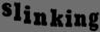

Result: 	 ALEPPO


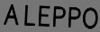

Result: 	 TWANDA


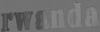

Result: 	 NATHANS


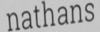

Result: 	 HALLO


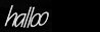

Result: 	 HURLS


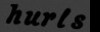

Result: 	 DOWNSIZE


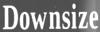

Result: 	 ROBOTIC


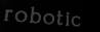

Result: 	 SLOPPY


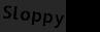

Result: 	 HERMITE


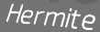

In [12]:
from IPython.display import display

test_set = MJDatasetSequence(TEST_DATA_PATH, label_converter, batch_size=BATCH_SIZE, character=TARGET_CHARACTERS)

model, y_func = build_crnn_model()

checkpoint_path = HOME_DIR + '/model_checkpoint.hdf5'
model.load_weights(checkpoint_path)
input_data = model.get_layer('input_image').output
y_pred = model.get_layer('output').output
model_pred = Model(inputs=input_data, outputs=y_pred)

def decode_predict_ctc(out, chars = TARGET_CHARACTERS, top_paths = 1):
    results = []
    beam_width = 5
    if beam_width < top_paths:
        beam_width = top_paths
    for i in range(top_paths):
        indexes = K.get_value(
            K.ctc_decode(
                out, input_length = np.ones(out.shape[0]) * out.shape[1],
                greedy =False , beam_width = beam_width, top_paths = top_paths
            )[0][i]
        )[0]
        text = ""
        for index in indexes:
            text += chars[index]
        results.append(text)
    return results

def check_inference(model, dataset, index = 5):
    for i in range(index):
        inputs, outputs = dataset[i]
        img = dataset[i][0]['input_image'][0:1,:,:,:]
        output = model_pred.predict(img)
        result = decode_predict_ctc(output, chars="-"+TARGET_CHARACTERS)[0].replace('-','')
        print("Result: \t", result)
        display(Image.fromarray(img[0].transpose(1,0,2).astype(np.uint8)))

check_inference(model, test_set, index=10)

## 2. OCR TEST

In [10]:
import cv2
import matplotlib.pyplot as plt
from keras_ocr.detection import Detector

SAMPLE_IMG_PATH = HOME_DIR + '/data/sample.jpg'

detector = Detector()

Looking for /aiffel/.keras-ocr/craft_mlt_25k.h5


In [11]:
def detect_text(img_path):
    img = cv2.imread(img_path)
    line_img = img.copy()
    input_img = img[tf.newaxis,...]
    result = detector.detect(input_img)
    ocr_result = result[0]
    
    cropped_imgs = []
    for text_result in ocr_result:
        for i in range(4):
            if i==3:
                line_img = cv2.line(line_img,tuple(text_result[3]),tuple(text_result[0]),(0,0,255),10)
            else:
                line_img = cv2.line(line_img,tuple(text_result[i]),tuple(text_result[i+1]),(0,0,255),10)
        
        x_min = text_result[:,0].min() - 5
        x_max = text_result[:,0].max() + 5
        y_min = text_result[:,1].min() - 5
        y_max = text_result[:,1].max() + 5
        cropped_imgs.append(img[int(y_min):int(y_max),int(x_min):int(x_max)])
    
    return line_img, cropped_imgs

In [12]:
def recognize_img(input_img, input_img_size=(100,32)):
    # 잘려진 단어 이미지를 인식하는 코드
    img = input_img[:,:,::-1]
    img = cv2.resize(img, input_img_size)
    result_img = img.copy()
    img = img.transpose(1,0,2)
    img = img[tf.newaxis,...]
    output = model_pred.predict(img)
    result = decode_predict_ctc(output, chars="-"+TARGET_CHARACTERS)[0].replace('-','')
    print("Result: \t", result)
    display(Image.fromarray(img[0].transpose(1,0,2).astype(np.uint8)))

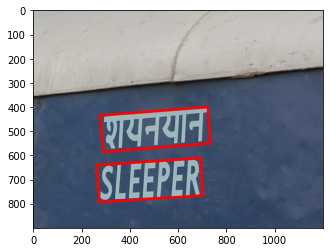

In [13]:
img, cropped_img = detect_text(SAMPLE_IMG_PATH)
plt.imshow(img[:,:,::-1])

Result: 	 RARE


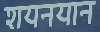

Result: 	 SLEEPER


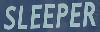

In [14]:
for _img in cropped_img:
    recognize_img(_img)

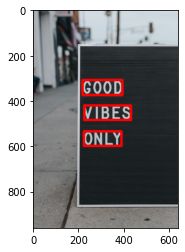

In [15]:
SAMPLE_IMG_PATH = os.path.join(HOME_DIR, 'sample.jpg')
img, cropped_img = detect_text(SAMPLE_IMG_PATH)
plt.imshow(img[:,:,::-1])

Result: 	 GOOD


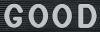

Result: 	 VIBES


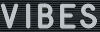

Result: 	 ONEY


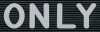

In [16]:
for _img in cropped_img:
    recognize_img(_img)

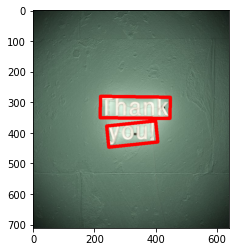

In [19]:
SAMPLE_IMG_PATH = os.path.join(HOME_DIR, 'sample1.jpg')
img, cropped_img = detect_text(SAMPLE_IMG_PATH)
plt.imshow(img[:,:,::-1])

Result: 	 THAK


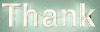

Result: 	 YORUL


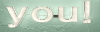

In [20]:
for _img in cropped_img:
    recognize_img(_img)

# 프로젝트 결과
- 첫번째 샘플에서 영어가 아닌 언어는 제대로 인식하지 않았고 영어는 정확하게 인식했다.
- 두번째 샘플에서 영어가 명확하게 있음에도 불구하고 L이 E로 잘못인식되는 점을 제외하고는 아주 잘 인식했다.
- 세번째 샘플에서 네온사인을 테스트 해봤는데 빛 때문인지 잘 인식을 못했다.